In [1]:
import pandas as pd
import requests

In [2]:
# API: default is 1000
limit = '$limit=100000000'

### FHV

https://data.cityofnewyork.us/Transportation/2020-For-Hire-Vehicles-Trip-Data/m3yx-mvk4

In [3]:
# base url
base_url_fhv = 'https://data.cityofnewyork.us/resource/m3yx-mvk4.json'

In [4]:
# filter for March and April
soql_filter_fhv = '?$where=date_extract_m(pickup_datetime) in (3, 4)'

In [5]:
# combine base url, filter, and limit
final_url_fhv = base_url_fhv + soql_filter_fhv + '&' + limit
print(final_url_fhv)

https://data.cityofnewyork.us/resource/m3yx-mvk4.json?$where=date_extract_m(pickup_datetime) in (3, 4)&$limit=100000000


In [6]:
# retrieve the data 
request_fhv = requests.get(url=final_url_fhv)
df_fhv = pd.DataFrame(request_fhv.json())

In [7]:
df_fhv.head()

,dispatching_base_num,pickup_datetime,dropoff_datetime,pulocationid,dolocationid
0,B00054,2020-03-01T07:43:00.000,2020-03-01T07:52:00.000,NaN,NaN
1,B00054,2020-03-01T07:13:00.000,2020-03-01T07:22:00.000,NaN,NaN
2,B00882,2020-03-01T10:36:59.000,2020-03-01T10:41:33.000,NaN,NaN
3,B00882,2020-03-01T10:49:31.000,2020-03-01T10:53:44.000,NaN,NaN
4,B00882,2020-03-01T10:44:34.000,2020-03-01T10:45:26.000,NaN,NaN


In [8]:
df_fhv.shape

(1730888, 5)

In [8]:
df_fhv.to_csv('raw_fhv.csv')

### High-Volume FHV 

https://data.cityofnewyork.us/Transportation/2020-High-Volume-FHV-Trip-Records/yrt9-58g8

In [9]:
# base url
base_url_hvfhv = 'https://data.cityofnewyork.us/resource/yrt9-58g8.json'

In [10]:
# filter for March and April
soql_filter_hvfhv = '?$where=date_extract_m(pickup_datetime) in (3, 4)'

In [11]:
# combine base url, filter, and limit
final_url_hvfhv = base_url_hvfhv + soql_filter_hvfhv + '&' + limit
print(final_url_hvfhv)

https://data.cityofnewyork.us/resource/yrt9-58g8.json?$where=date_extract_m(pickup_datetime) in (3, 4)&$limit=100000000


In [12]:
# retrieve the data 
request_hvfhv = requests.get(url=final_url_hvfhv)
df_hvfhv = pd.DataFrame(request_hvfhv.json())

In [13]:
df_hvfhv.head()

,hvfhs_license_num,dispatching_base_num,pickup_datetime,dropoff_datetime,pulocationid,dolocationid,sr_flag
0,HV0005,B02510,2020-03-01T00:03:40.000,2020-03-01T00:23:39.000,81,159,NaN
1,HV0005,B02510,2020-03-01T00:28:05.000,2020-03-01T00:38:57.000,168,119,NaN
2,HV0003,B02764,2020-03-01T00:03:07.000,2020-03-01T00:15:04.000,137,209,1
3,HV0003,B02764,2020-03-01T00:18:42.000,2020-03-01T00:38:42.000,209,80,NaN
4,HV0003,B02764,2020-03-01T00:44:24.000,2020-03-01T00:58:44.000,256,226,NaN


In [14]:
df_hvfhv.shape

(17705813, 7)

In [15]:
df_hvfhv.to_csv('raw_hvfhv.csv')

### Data Cleaning

#### hvhfs_license_num (High-Volume FHV)

The TLC License number of the HVFHS base or business 
- HV0002: Juno
- HV0003: Uber
- HV0004: Via
- HV0005:Lyft

In [16]:
df_hvfhv['hvfhs_license_num'].unique()

array(['HV0005', 'HV0003', 'HV0004'], dtype=object)

In [17]:
df_hvfhv.groupby(['hvfhs_license_num']).agg({'hvfhs_license_num': 'count'})

,hvfhs_license_num
hvfhs_license_num,
HV0003,12939598
HV0004,402597
HV0005,4363618


#### sr_flag (High-Volume FHV)

Indicates if the trip was a part of a shared ride chain offered by a High Volume FHV company (e.g. Uber Pool, Lyft Line). For shared trips, the value is 1. For non-shared rides, this field is null.

NOTE: For most High Volume FHV companies, only shared rides that were requested AND matched to another shared-ride request over the course of the journey are flagged. However, Lyft (hvfhs_license_num=’HV0005’) also flags rides for which a shared ride was requested but another passenger was not successfully matched to share the trip—therefore, trips records with SR_Flag=1 from those two bases could indicate EITHER a trip in a shared trip chain OR a trip for which a shared ride was requested but never matched. Users should anticipate an overcount of successfully shared trips completed by Lyft. 

Note also that Juno does not offer shared trips

In [18]:
df_hvfhv['sr_flag'].unique()

array([nan, '1'], dtype=object)

In [19]:
df_hvfhv.groupby(['sr_flag']).agg({'sr_flag': 'count'})

,sr_flag
sr_flag,
1,1272581


#### Merge

In [20]:
# define function to look up company name
def company(x):
    if x == 'HV0003':
        return 'Uber'
    elif x == 'HV0004':
        return 'Via'
    elif x == 'HV0005':
        return 'Lyft'
    else:
        return null

In [21]:
# add fhv type
df_fhv['type'] = 'fhv'
df_hvfhv['type'] = df_hvfhv['hvfhs_license_num'].apply(company)

In [22]:
df_fhv_base = df_fhv[['pickup_datetime', 'dropoff_datetime', 'pulocationid', 'dolocationid', 'type']]
df_fhv_base.head()

,pickup_datetime,dropoff_datetime,pulocationid,dolocationid,type
0,2020-03-01T07:43:00.000,2020-03-01T07:52:00.000,NaN,NaN,fhv
1,2020-03-01T07:13:00.000,2020-03-01T07:22:00.000,NaN,NaN,fhv
2,2020-03-01T10:36:59.000,2020-03-01T10:41:33.000,NaN,NaN,fhv
3,2020-03-01T10:49:31.000,2020-03-01T10:53:44.000,NaN,NaN,fhv
4,2020-03-01T10:44:34.000,2020-03-01T10:45:26.000,NaN,NaN,fhv


In [23]:
df_hvfhv_base = df_hvfhv[['pickup_datetime', 'dropoff_datetime', 'pulocationid', 'dolocationid', 'type']]
df_hvfhv_base.head()

,pickup_datetime,dropoff_datetime,pulocationid,dolocationid,type
0,2020-03-01T00:03:40.000,2020-03-01T00:23:39.000,81,159,Lyft
1,2020-03-01T00:28:05.000,2020-03-01T00:38:57.000,168,119,Lyft
2,2020-03-01T00:03:07.000,2020-03-01T00:15:04.000,137,209,Uber
3,2020-03-01T00:18:42.000,2020-03-01T00:38:42.000,209,80,Uber
4,2020-03-01T00:44:24.000,2020-03-01T00:58:44.000,256,226,Uber


In [24]:
df_fhvall = pd.concat([df_fhv_base, df_hvfhv_base], axis=0)
df_fhvall.head()

,pickup_datetime,dropoff_datetime,pulocationid,dolocationid,type
0,2020-03-01T07:43:00.000,2020-03-01T07:52:00.000,NaN,NaN,fhv
1,2020-03-01T07:13:00.000,2020-03-01T07:22:00.000,NaN,NaN,fhv
2,2020-03-01T10:36:59.000,2020-03-01T10:41:33.000,NaN,NaN,fhv
3,2020-03-01T10:49:31.000,2020-03-01T10:53:44.000,NaN,NaN,fhv
4,2020-03-01T10:44:34.000,2020-03-01T10:45:26.000,NaN,NaN,fhv


In [25]:
df_fhvall.shape

(19436701, 5)

In [26]:
df_fhvall['pickup_datetime'] = pd.to_datetime(df_fhvall['pickup_datetime'])
df_fhvall['dropoff_datettime'] = pd.to_datetime(df_fhvall['dropoff_datetime'])

In [27]:
df_fhvall['pu_year'] = df_fhvall['pickup_datetime'].dt.year
df_fhvall['pu_month'] = df_fhvall['pickup_datetime'].dt.month
df_fhvall['pu_day'] = df_fhvall['pickup_datetime'].dt.day
df_fhvall['pu_hour'] = df_fhvall['pickup_datetime'].dt.hour

In [28]:
df_fhvall.head()

,pickup_datetime,dropoff_datetime,pulocationid,dolocationid,type,dropoff_datettime,pu_year,pu_month,pu_day,pu_hour
0,2020-03-01 07:43:00,2020-03-01T07:52:00.000,NaN,NaN,fhv,2020-03-01 07:52:00,2020,3,1,7
1,2020-03-01 07:13:00,2020-03-01T07:22:00.000,NaN,NaN,fhv,2020-03-01 07:22:00,2020,3,1,7
2,2020-03-01 10:36:59,2020-03-01T10:41:33.000,NaN,NaN,fhv,2020-03-01 10:41:33,2020,3,1,10
3,2020-03-01 10:49:31,2020-03-01T10:53:44.000,NaN,NaN,fhv,2020-03-01 10:53:44,2020,3,1,10
4,2020-03-01 10:44:34,2020-03-01T10:45:26.000,NaN,NaN,fhv,2020-03-01 10:45:26,2020,3,1,10


### Trip Count

In [36]:
df_agg_pu = df_fhvall.groupby(['type', 'pu_month', 'pu_day', 'pu_hour', 'pulocationid']).agg({'pickup_datetime': 'count'}).rename(columns={'pickup_datetime': 'trips'})
df_agg_pu.head()

trips
type pu_month pu_day pu_hour pulocationid       
Lyft 3        1      0       10               12
                             100              78
                             101               1
                             102              16
                             106              70

In [37]:
df_agg_do = df_fhvall.groupby(['type', 'pu_month', 'pu_day', 'pu_hour', 'dolocationid']).agg({'dropoff_datetime': 'count'}).rename(columns={'dropoff_datetime': 'trips'})
df_agg_do.head()

trips
type pu_month pu_day pu_hour dolocationid       
Lyft 3        1      0       10               27
                             100              54
                             101               5
                             102              21
                             106              30

In [38]:
df_agg_pu.shape

(876244, 1)

In [39]:
df_agg_do.shape

(999900, 1)

In [40]:
df_agg_pu.to_csv('fhv_pickup.csv')

In [41]:
df_agg_do.to_csv('fhv_dropoff.csv')

In [29]:
df_fhvall.head()

,pickup_datetime,dropoff_datetime,pulocationid,dolocationid,type,dropoff_datettime,pu_year,pu_month,pu_day,pu_hour
0,2020-03-01 07:43:00,2020-03-01T07:52:00.000,NaN,NaN,fhv,2020-03-01 07:52:00,2020,3,1,7
1,2020-03-01 07:13:00,2020-03-01T07:22:00.000,NaN,NaN,fhv,2020-03-01 07:22:00,2020,3,1,7
2,2020-03-01 10:36:59,2020-03-01T10:41:33.000,NaN,NaN,fhv,2020-03-01 10:41:33,2020,3,1,10
3,2020-03-01 10:49:31,2020-03-01T10:53:44.000,NaN,NaN,fhv,2020-03-01 10:53:44,2020,3,1,10
4,2020-03-01 10:44:34,2020-03-01T10:45:26.000,NaN,NaN,fhv,2020-03-01 10:45:26,2020,3,1,10


In [32]:
df_fhvall.tail()

,pickup_datetime,dropoff_datetime,pulocationid,dolocationid,type,dropoff_datettime,pu_year,pu_month,pu_day,pu_hour,pu_week
17705808,2020-04-30 23:13:55,2020-04-30T23:24:03.000,78,126,Lyft,2020-04-30 23:24:03,2020,4,30,23,18
17705809,2020-04-30 23:32:35,2020-04-30T23:37:18.000,167,147,Lyft,2020-04-30 23:37:18,2020,4,30,23,18
17705810,2020-04-30 23:42:19,2020-04-30T23:50:02.000,147,167,Lyft,2020-04-30 23:50:02,2020,4,30,23,18
17705811,2020-04-30 23:12:58,2020-04-30T23:25:10.000,260,193,Uber,2020-04-30 23:25:10,2020,4,30,23,18
17705812,2020-04-30 23:32:38,2020-04-30T23:49:12.000,140,247,Uber,2020-04-30 23:49:12,2020,4,30,23,18


In [31]:
df_fhvall['pu_week'] = df_fhvall['pickup_datetime'].dt.week

<ipython-input-31-43dc8f739a31>:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df_fhvall['pu_week'] = df_fhvall['pickup_datetime'].dt.week


In [33]:
df_fhvall.head()

,pickup_datetime,dropoff_datetime,pulocationid,dolocationid,type,dropoff_datettime,pu_year,pu_month,pu_day,pu_hour,pu_week
0,2020-03-01 07:43:00,2020-03-01T07:52:00.000,NaN,NaN,fhv,2020-03-01 07:52:00,2020,3,1,7,9
1,2020-03-01 07:13:00,2020-03-01T07:22:00.000,NaN,NaN,fhv,2020-03-01 07:22:00,2020,3,1,7,9
2,2020-03-01 10:36:59,2020-03-01T10:41:33.000,NaN,NaN,fhv,2020-03-01 10:41:33,2020,3,1,10,9
3,2020-03-01 10:49:31,2020-03-01T10:53:44.000,NaN,NaN,fhv,2020-03-01 10:53:44,2020,3,1,10,9
4,2020-03-01 10:44:34,2020-03-01T10:45:26.000,NaN,NaN,fhv,2020-03-01 10:45:26,2020,3,1,10,9


In [34]:
df_fhvall['pu_week'].unique()

array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])

In [37]:
len(df_fhvall['pulocationid'].unique())

264

In [38]:
len(df_fhvall['dolocationid'].unique())

264

In [69]:
def period(hour):
    if hour in (1, 2, 3, 4):
        return 'midnight'
    elif hour in (5, 6, 7, 8, 9, 10):
        return 'morning'
    elif hour in (11, 12, 13, 14, 15, 16):
        return 'daytime'
    elif hour in (17, 18, 19, 20, 21, 22, 23, 0):
        return 'night'

In [70]:
df_fhvall['pu_period'] = df_fhvall['pu_hour'].apply(period)
df_fhvall.head()

,pickup_datetime,dropoff_datetime,pulocationid,dolocationid,type,dropoff_datettime,pu_year,pu_month,pu_day,pu_hour,pu_week,pu_period
0,2020-03-01 07:43:00,2020-03-01T07:52:00.000,NaN,NaN,fhv,2020-03-01 07:52:00,2020,3,1,7,9,morning
1,2020-03-01 07:13:00,2020-03-01T07:22:00.000,NaN,NaN,fhv,2020-03-01 07:22:00,2020,3,1,7,9,morning
2,2020-03-01 10:36:59,2020-03-01T10:41:33.000,NaN,NaN,fhv,2020-03-01 10:41:33,2020,3,1,10,9,morning
3,2020-03-01 10:49:31,2020-03-01T10:53:44.000,NaN,NaN,fhv,2020-03-01 10:53:44,2020,3,1,10,9,morning
4,2020-03-01 10:44:34,2020-03-01T10:45:26.000,NaN,NaN,fhv,2020-03-01 10:45:26,2020,3,1,10,9,morning


In [71]:
# morning
df_morning = df_fhvall[df_fhvall['pu_period'] == 'morning']\
             .groupby(['pu_week', 'pulocationid', 'dolocationid'])\
             .agg({'pickup_datetime': 'count'})\
             .rename(columns={'pickup_datetime':'trips'})\
             .reset_index()
df_morning

,pu_week,pulocationid,dolocationid,trips
0,9,1,107,1
1,9,1,170,1
2,9,1,195,1
3,9,1,249,1
4,9,1,265,3
...,...,...,...,...
286436,18,98,95,4
286437,18,98,98,1
286438,18,99,118,1
286439,18,99,23,1


In [57]:
df_morning[df_morning['trips'] >= 5]

,pu_week,pulocationid,dolocationid,trips
7,9,10,10,19
20,9,10,130,72
22,9,10,132,52
26,9,10,139,12
42,9,10,191,9
...,...,...,...,...
286407,18,98,16,6
286410,18,98,171,5
286422,18,98,265,7
286432,18,98,82,6


In [63]:
df_morning[(df_morning['pulocationid'] == '10') & (df_morning['dolocationid'] == '130')]

,pu_week,pulocationid,dolocationid,trips
20,9,10,130,72
21278,10,10,130,1241
59728,11,10,130,1125
97009,12,10,130,492
129470,13,10,130,258
156183,14,10,130,190
182322,15,10,130,203
208095,16,10,130,221
235142,17,10,130,234
262549,18,10,130,165


In [64]:
df_morning[(df_morning['pulocationid'] == '10') & (df_morning['dolocationid'] == '132')]

,pu_week,pulocationid,dolocationid,trips
22,9,10,132,52
21280,10,10,132,496
59730,11,10,132,418
97011,12,10,132,295
129472,13,10,132,149
156185,14,10,132,114
182324,15,10,132,78
208097,16,10,132,63
235144,17,10,132,71
262551,18,10,132,37


In [65]:
df_morning[(df_morning['pulocationid'] == '98') & (df_morning['dolocationid'] == '265')]

,pu_week,pulocationid,dolocationid,trips
21192,9,98,265,4
59626,10,98,265,52
96925,11,98,265,51
129415,12,98,265,27
156144,13,98,265,10
182284,14,98,265,12
208061,15,98,265,8
235103,16,98,265,9
262514,17,98,265,7
286422,18,98,265,7


<AxesSubplot:xlabel='pu_week'>

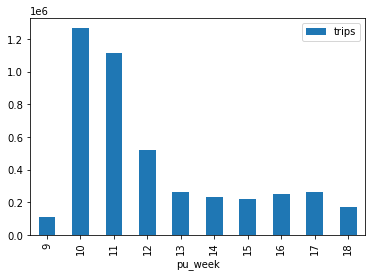

In [68]:
df_morning[df_morning['trips'] >= 5].groupby(['pu_week']).agg({'trips':'sum'}).plot.bar()

In [72]:
# daytime
df_daytime = df_fhvall[df_fhvall['pu_period'] == 'daytime']\
             .groupby(['pu_week', 'pulocationid', 'dolocationid'])\
             .agg({'pickup_datetime': 'count'})\
             .rename(columns={'pickup_datetime':'trips'})\
             .reset_index()
df_daytime

,pu_week,pulocationid,dolocationid,trips
0,9,1,107,1
1,9,1,112,1
2,9,1,125,2
3,9,1,142,1
4,9,1,144,1
...,...,...,...,...
308752,18,98,98,3
308753,18,99,109,1
308754,18,99,23,1
308755,18,99,251,5


<AxesSubplot:xlabel='pu_week'>

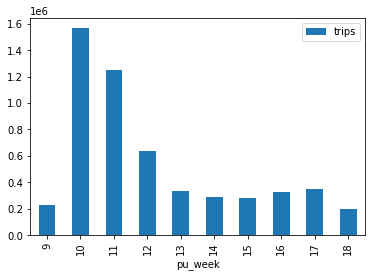

In [73]:
df_daytime[df_daytime['trips'] >= 5].groupby(['pu_week']).agg({'trips':'sum'}).plot.bar()

In [74]:
# night
df_night = df_fhvall[df_fhvall['pu_period'] == 'night']\
             .groupby(['pu_week', 'pulocationid', 'dolocationid'])\
             .agg({'pickup_datetime': 'count'})\
             .rename(columns={'pickup_datetime':'trips'})\
             .reset_index()
df_night

,pu_week,pulocationid,dolocationid,trips
0,9,1,109,1
1,9,1,113,1
2,9,1,114,1
3,9,1,125,1
4,9,1,13,2
...,...,...,...,...
326077,18,98,95,3
326078,18,98,98,8
326079,18,99,204,2
326080,18,99,44,1


<AxesSubplot:xlabel='pu_week'>

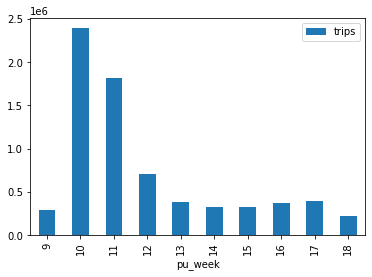

In [75]:
df_night[df_night['trips'] >= 5].groupby(['pu_week']).agg({'trips':'sum'}).plot.bar()

In [76]:
# midnight
df_midnight = df_fhvall[df_fhvall['pu_period'] == 'midnight']\
             .groupby(['pu_week', 'pulocationid', 'dolocationid'])\
             .agg({'pickup_datetime': 'count'})\
             .rename(columns={'pickup_datetime':'trips'})\
             .reset_index()
df_midnight

,pu_week,pulocationid,dolocationid,trips
0,9,10,10,14
1,9,10,117,3
2,9,10,121,1
3,9,10,122,5
4,9,10,124,1
...,...,...,...,...
168650,18,98,225,1
168651,18,98,265,3
168652,18,98,28,3
168653,18,98,37,1


<AxesSubplot:xlabel='pu_week'>

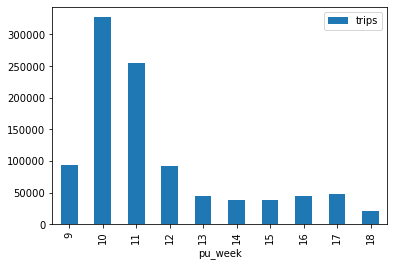

In [77]:
df_midnight[df_midnight['trips'] >= 5].groupby(['pu_week']).agg({'trips':'sum'}).plot.bar()